# Dialogue Model Fine-Tuning Template 🤖

**Purpose:** Fine-tune LLaMA/Mistral models for dialogue generation using LoRA

**What this notebook does:**
- 📚 Load and preprocess Love Is Blind dialogue data
- 🎯 Fine-tune LLaMA/Mistral with LoRA (memory efficient)
- 🎭 Support both basic and emotion-conditioned modes
- 📊 Monitor training with live visualizations
- 💾 Save and test your fine-tuned model

**Single GPU Optimizations:**
- LoRA: Train <1% of parameters
- Gradient checkpointing: Reduce memory by ~40%
- Mixed precision (FP16): 2x faster training
- Gradient accumulation: Simulate larger batch sizes

**Memory Requirements:** ~12-14GB for LLaMA-7B

---

## 1. Setup and Configuration

In [1]:
!pip3 install torch
!pip3 install pandas
!pip3 install numpy
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install transformers
!pip3 install datasets
!pip3 install accelerate
!pip3 install bitsandbytes
!pip3 install tensorboard
!pip3 install pyyaml
!pip3 install peft

In [2]:
# Check environment
import sys
from pathlib import Path

# Add parent to path
if Path.cwd().name == 'notebooks':
    sys.path.insert(0, str(Path.cwd().parent))
    print("✓ Running from notebooks directory")
else:
    print(f"⚠️  Current directory: {Path.cwd()}")
    print("Please run from notebooks/ directory")

✓ Running from notebooks directory


In [3]:
# Core imports
import torch
import json
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

# Transformers and PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from datasets import Dataset, DatasetDict

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

/common/home/projectgrps/CS425/CS425G3/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    
    # Clear cache
    torch.cuda.empty_cache()
else:
    print("⚠️  No GPU detected - training will be VERY slow")

Device: cuda
GPU: NVIDIA L40S
Memory: 47.67 GB
CUDA Version: 12.8


## 2. Training Configuration

**⚠️ CUSTOMIZE THESE SETTINGS:**

In [5]:
# ==================== CONFIGURATION ====================

# Model settings
MODEL_NAME = "meta-llama/Llama-2-7b-hf"  # or "mistralai/Mistral-7B-v0.1"
# Note: You'll need HuggingFace access token for LLaMA models

# Training mode
EMOTION_CONDITIONED = False  # Set True to include emotion labels

# Data paths
DATA_PATH = "../data/processed/love_is_blind/love_is_blind_cleaned.csv"
OUTPUT_DIR = "../checkpoints/dialogue_finetuned"

# Training hyperparameters
CONFIG = {
    # Data
    'max_length': 256,  # Maximum sequence length
    'train_split': 0.9,  # 90% train, 10% validation
    
    # Training
    'num_epochs': 3,
    'batch_size': 1,  # Per-device batch size (small for memory)
    'gradient_accumulation_steps': 8,  # Effective batch = 1 * 8 = 8
    'learning_rate': 2e-4,
    'warmup_steps': 100,
    'weight_decay': 0.01,
    
    # LoRA parameters
    'lora_r': 8,  # LoRA rank (higher = more params, better quality)
    'lora_alpha': 16,  # LoRA alpha (scaling factor)
    'lora_dropout': 0.05,
    'lora_target_modules': ['q_proj', 'v_proj', 'k_proj', 'o_proj'],  # Which layers to adapt
    
    # Memory optimization
    'gradient_checkpointing': True,
    'fp16': True,  # Use mixed precision (set False if bf16 supported)
    'bf16': False,  # Use bfloat16 (better for newer GPUs like A100)
    
    # Logging
    'logging_steps': 10,
    'eval_steps': 100,
    'save_steps': 500,
    'save_total_limit': 3,  # Keep only 3 best checkpoints
}

# HuggingFace token (required for LLaMA)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  max_length: 256
  train_split: 0.9
  num_epochs: 3
  batch_size: 1
  gradient_accumulation_steps: 8
  learning_rate: 0.0002
  warmup_steps: 100
  weight_decay: 0.01
  lora_r: 8
  lora_alpha: 16
  lora_dropout: 0.05
  lora_target_modules: ['q_proj', 'v_proj', 'k_proj', 'o_proj']
  gradient_checkpointing: True
  fp16: True
  bf16: False
  logging_steps: 10
  eval_steps: 100
  save_steps: 500
  save_total_limit: 3


## 3. Load and Explore Data

In [6]:
# Load raw data
print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

print(f"\nLoaded {len(df)} text samples")
print(f"\nFirst few samples:")
df.head(10)

Loading data from: ../data/processed/love_is_blind/love_is_blind_cleaned.csv

Loaded 13597 text samples

First few samples:


,text
0,"When I heard about this experiment, I knew it ..."
1,It was the opposite of what modern dating has ...
2,"There's so many dating apps,"
3,and most of them are based off of your physica...
4,"It's not all about physical attraction, in the..."
5,It's who's holding your hand on your deathbed.
6,The reason I came here is
7,"there's men who actually want to get married, ..."
8,They're looking for wives.
9,"I'm like, ""What? Where?"""


Text Length Statistics:
count    13595.000000
mean         6.168665
std          3.641952
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         20.000000
Name: text_length, dtype: float64


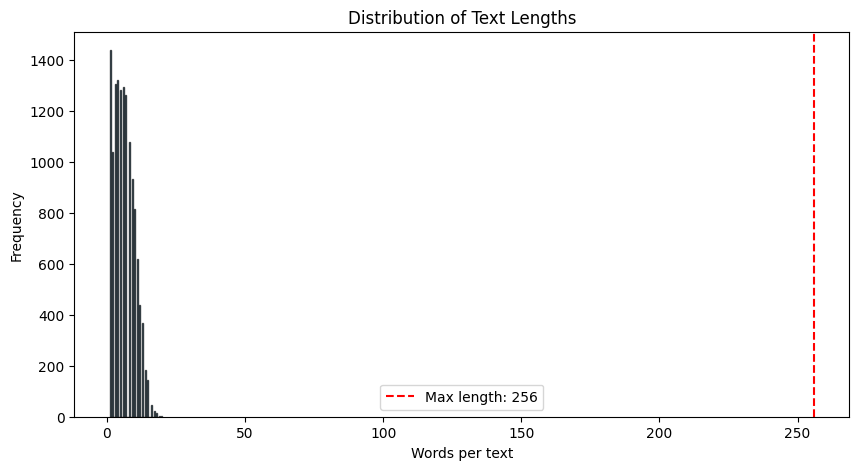

In [7]:
# Basic statistics
df['text_length'] = df['text'].str.split().str.len()

print("Text Length Statistics:")
print(df['text_length'].describe())

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Words per text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.axvline(CONFIG['max_length'], color='red', linestyle='--', label=f'Max length: {CONFIG["max_length"]}')
plt.legend()
plt.show()

## 4. Prepare Dialogue Dataset

Convert raw text into dialogue pairs (context → response)

In [8]:
def create_dialogue_pairs(texts, window_size=2):
    """
    Create dialogue pairs from sequential texts.
    
    Args:
        texts: List of text utterances
        window_size: Number of previous utterances to use as context
    
    Returns:
        List of (context, response) pairs
    """
    pairs = []
    
    for i in range(window_size, len(texts)):
        # Context: previous utterances
        context = texts[i-window_size:i]
        # Response: current utterance
        response = texts[i]
        
        # Check if Context, Response are string types
        if not all(isinstance(utt, str) for utt in context) or not isinstance(response, str):
            print(f"Skipping non-string data at index {i}")
            print(f"Context: {context}")
            print(f"Response: {response}")
            continue

        pairs.append({
            'context': ' '.join(context),
            'response': response
        })
    
    return pairs

# Create dialogue pairs
print("Creating dialogue pairs...")
texts = df['text'].tolist()
dialogue_pairs = create_dialogue_pairs(texts, window_size=2)

print(f"\nCreated {len(dialogue_pairs)} dialogue pairs")
print(f"\nExample pairs:")
for i, pair in enumerate(dialogue_pairs[:3]):
    print(f"\n--- Pair {i+1} ---")
    print(f"Context:  {pair['context'][:100]}...")
    print(f"Response: {pair['response'][:100]}...")

Creating dialogue pairs...
Skipping non-string data at index 7957
Context: ["If he doesn't want to talk about it, then I'm done.", 'Oh, fuck me.']
Response: nan
Skipping non-string data at index 7958
Context: ['Oh, fuck me.', nan]
Response: There you go, boy.
Skipping non-string data at index 7959
Context: [nan, 'There you go, boy.']
Response: Oh!
Skipping non-string data at index 8008
Context: ["It's gonna work out the way it needs to.", 'It will.']
Response: nan
Skipping non-string data at index 8009
Context: ['It will.', nan]
Response: It'll be good.
Skipping non-string data at index 8010
Context: [nan, "It'll be good."]
Response: Mm-hmm.

Created 13589 dialogue pairs

Example pairs:

--- Pair 1 ---
Context:  When I heard about this experiment, I knew it was for me. It was the opposite of what modern dating ...
Response: There's so many dating apps,...

--- Pair 2 ---
Context:  It was the opposite of what modern dating has become. There's so many dating apps,...
Response: and most o

In [9]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_list(dialogue_pairs)

# Train/validation split
train_test = dataset.train_test_split(
    test_size=1-CONFIG['train_split'],
    seed=42
)

train_dataset = train_test['train']
val_dataset = train_test['test']

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 12230
Validation samples: 1359


## 5. Load Model and Tokenizer

In [ ]:
from huggingface_hub import login
login(token="") # TODO: Add your HuggingFace token here to access LLaMA models

In [15]:
# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token = eos_token")

print(f"✓ Tokenizer loaded")
print(f"  Vocab size: {len(tokenizer)}")
print(f"  Pad token: {tokenizer.pad_token}")
print(f"  EOS token: {tokenizer.eos_token}")

Loading tokenizer: meta-llama/Llama-2-7b-hf
Set pad_token = eos_token
✓ Tokenizer loaded
  Vocab size: 32000
  Pad token: </s>
  EOS token: </s>


In [16]:
# Load base model
print(f"\nLoading model: {MODEL_NAME}")
print("This may take a few minutes...\n")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if CONFIG['fp16'] else torch.bfloat16 if CONFIG['bf16'] else torch.float32,
    device_map='auto',  # Automatically distribute across available GPU(s)
    trust_remote_code=True
)

print("✓ Model loaded")

# Model info
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Size: ~{total_params * 2 / 1e9:.2f} GB (FP16)")


Loading model: meta-llama/Llama-2-7b-hf
This may take a few minutes...



Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


✓ Model loaded
  Total parameters: 6,738,415,616
  Size: ~13.48 GB (FP16)


## 6. Configure LoRA

LoRA dramatically reduces trainable parameters and memory usage

In [17]:
# Prepare model for training
if CONFIG['gradient_checkpointing']:
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled")

# LoRA configuration
lora_config = LoraConfig(
    r=CONFIG['lora_r'],
    lora_alpha=CONFIG['lora_alpha'],
    target_modules=CONFIG['lora_target_modules'],
    lora_dropout=CONFIG['lora_dropout'],
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA
model = get_peft_model(model, lora_config)

print("\n✓ LoRA applied")
model.print_trainable_parameters()

# Calculate memory savings
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMemory for trainable params: ~{trainable_params * 2 / 1e9:.3f} GB (FP16)")

✓ Gradient checkpointing enabled

✓ LoRA applied
trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.1243

Memory for trainable params: ~0.017 GB (FP16)


## 7. Prepare Training Data

In [18]:
def format_dialogue(example, emotion_conditioned=False):
    """
    Format dialogue pair for training.
    
    Basic format:
        User: {context}
        Assistant: {response}
    
    Emotion-conditioned format:
        Emotion: {emotion}
        User: {context}
        Assistant: {response}
    """
    if emotion_conditioned and 'emotion' in example:
        prompt = f"Emotion: {example['emotion']}\nUser: {example['context']}\nAssistant: {example['response']}"
    else:
        prompt = f"User: {example['context']}\nAssistant: {example['response']}"
    
    return prompt

def tokenize_function(examples):
    """Tokenize dialogue pairs."""
    # Format dialogues
    formatted = [format_dialogue(ex, EMOTION_CONDITIONED) for ex in examples]
    
    # Tokenize
    tokenized = tokenizer(
        formatted,
        truncation=True,
        max_length=CONFIG['max_length'],
        padding='max_length',
        return_tensors='pt'
    )
    
    # For causal LM, labels = input_ids
    tokenized['labels'] = tokenized['input_ids'].clone()
    
    return tokenized

# Test formatting
print("Example formatted prompt:")
print("="*60)
sample = train_dataset[0]
formatted = format_dialogue(sample, EMOTION_CONDITIONED)
print(formatted)
print("="*60)

Example formatted prompt:
User: You're going to face so many challenges. How are you guys going to integrate your lives?
Assistant: Your friends, your families, your careers, your homes.


In [19]:
# Tokenize datasets
print("Tokenizing datasets...")

# Convert to list of dicts for processing
train_data = [train_dataset[i] for i in range(len(train_dataset))]
val_data = [val_dataset[i] for i in range(len(val_dataset))]

train_tokenized = tokenize_function(train_data)
val_tokenized = tokenize_function(val_data)

# Create torch datasets
class DialogueDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_torch_dataset = DialogueDataset(train_tokenized)
val_torch_dataset = DialogueDataset(val_tokenized)

print(f"✓ Tokenization complete")
print(f"  Train samples: {len(train_torch_dataset)}")
print(f"  Val samples: {len(val_torch_dataset)}")

Tokenizing datasets...
✓ Tokenization complete
  Train samples: 12230
  Val samples: 1359


## 8. Configure Training

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    
    # Optimization
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    lr_scheduler_type='cosine',
    
    # Memory optimization
    fp16=CONFIG['fp16'],
    bf16=CONFIG['bf16'],
    gradient_checkpointing=CONFIG['gradient_checkpointing'],
    
    # Logging and saving
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=CONFIG['logging_steps'],
    eval_steps=CONFIG['eval_steps'],
    save_steps=CONFIG['save_steps'],
    save_total_limit=CONFIG['save_total_limit'],
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    
    # Other
    report_to='tensorboard',
    remove_unused_columns=False,
)

print("Training configuration:")
print(f"  Output dir: {OUTPUT_DIR}")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"  Total steps: {len(train_torch_dataset) // (CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']) * CONFIG['num_epochs']}")
print(f"  Mixed precision: {'FP16' if CONFIG['fp16'] else 'BF16' if CONFIG['bf16'] else 'FP32'}")

Training configuration:
  Output dir: ../checkpoints/dialogue_finetuned
  Effective batch size: 8
  Total steps: 4584
  Mixed precision: FP16


In [21]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_torch_dataset,
    eval_dataset=val_torch_dataset,
    data_collator=data_collator,
)

print("✓ Trainer initialized")

The model is already on multiple devices. Skipping the move to device specified in `args`.


✓ Trainer initialized


## 9. Start Training! 🚀

**Note:** This will take a while depending on your GPU and dataset size.

For LLaMA-7B on a 16GB GPU with these settings:
- Expected time: ~30-60 minutes per epoch
- Memory usage: ~12-14GB

In [22]:
# Clear GPU cache before training
import gc
gc.collect()
torch.cuda.empty_cache()

print("Starting training...")
print(f"Monitor progress in TensorBoard: tensorboard --logdir {OUTPUT_DIR}/logs")
print()

Starting training...
Monitor progress in TensorBoard: tensorboard --logdir ../checkpoints/dialogue_finetuned/logs



In [23]:
# Train!
train_result = trainer.train()

print("\n" + "="*60)
print("Training Complete! 🎉")
print("="*60)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
100,2.049000,1.960755
200,1.961300,1.926128
300,1.892000,1.903256
400,1.935100,1.894199
500,1.786900,1.882966
600,1.877900,1.875552
700,1.849600,1.857782
800,1.814300,1.851648
900,1.881800,1.838557
1000,1.814200,1.823154



Training Complete! 🎉
Training loss: 1.5854
Training time: 6620.70 seconds


## 10. Save Model

In [24]:
# Save final model
final_model_path = f"{OUTPUT_DIR}/final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✓ Model saved to: {final_model_path}")

# Save training metrics
metrics_path = f"{OUTPUT_DIR}/training_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(train_result.metrics, f, indent=2)

print(f"✓ Metrics saved to: {metrics_path}")

✓ Model saved to: ../checkpoints/dialogue_finetuned/final
✓ Metrics saved to: ../checkpoints/dialogue_finetuned/training_metrics.json


## 11. Test the Model! 🎮

In [25]:
# Set model to eval mode
model.eval()

def generate_response(context, max_new_tokens=100, temperature=0.9, top_p=0.9):
    """Generate a response given context."""
    # Format prompt
    if EMOTION_CONDITIONED:
        prompt = f"Emotion: joy\nUser: {context}\nAssistant:"
    else:
        prompt = f"User: {context}\nAssistant:"
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the response part
    response = generated.split('Assistant:')[-1].strip()
    
    return response

print("✓ Generation function ready")

✓ Generation function ready


In [26]:
# Test with sample contexts
test_contexts = [
    "Hi! How are you doing today?",
    "What do you like to do for fun?",
    "Tell me about yourself.",
    "What's your ideal first date?",
]

print("Testing fine-tuned model:\n")
print("="*60)

for context in test_contexts:
    response = generate_response(context)
    print(f"User: {context}")
    print(f"Bot:  {response}")
    print("-"*60)

Testing fine-tuned model:

User: Hi! How are you doing today?
Bot:  You're so weird. Stop. I'm just kidd
------------------------------------------------------------
User: What do you like to do for fun?
Bot:  It's kinda crazy. It's kinda awesome. But
------------------------------------------------------------
User: Tell me about yourself.
Bot:  I'm so
------------------------------------------------------------
User: What's your ideal first date?
Bot:  That's good. That's good. I like that. I'm into that. Okay. That's good
------------------------------------------------------------


In [27]:
# Interactive testing
print("Interactive mode - Type 'quit' to exit\n")

while True:
    user_input = input("You: ")
    
    if user_input.lower() == 'quit':
        break
    
    response = generate_response(user_input)
    print(f"Bot: {response}\n")

Interactive mode - Type 'quit' to exit



You:  Hello, nice to meet you


Bot: get that reward at the end. I mean, I couldn't be more... happy, and I



You:  What are your hobbies


Bot: Okay, I'm not a little bit. I'm 100%... I'm 100%... I'm 100%... I'm 100%... I'm 100%... I'm 10



KeyboardInterrupt: Interrupted by user

## 12. Training Visualization

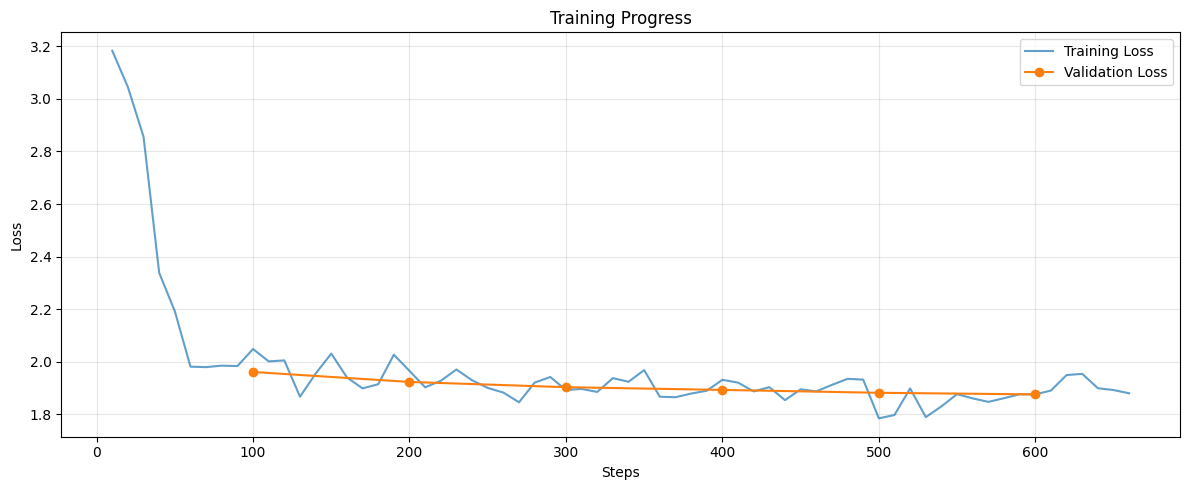

In [28]:
# Load training logs
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Find tensorboard logs
log_files = glob.glob(f"{OUTPUT_DIR}/logs/events.out.tfevents.*")

if log_files:
    event_acc = EventAccumulator(log_files[0])
    event_acc.Reload()
    
    # Extract training loss
    train_loss = event_acc.Scalars('train/loss') if 'train/loss' in event_acc.Tags()['scalars'] else []
    eval_loss = event_acc.Scalars('eval/loss') if 'eval/loss' in event_acc.Tags()['scalars'] else []
    
    if train_loss:
        # Plot losses
        fig, ax = plt.subplots(figsize=(12, 5))
        
        steps = [s.step for s in train_loss]
        values = [s.value for s in train_loss]
        ax.plot(steps, values, label='Training Loss', alpha=0.7)
        
        if eval_loss:
            eval_steps = [s.step for s in eval_loss]
            eval_values = [s.value for s in eval_loss]
            ax.plot(eval_steps, eval_values, label='Validation Loss', marker='o')
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')
        ax.set_title('Training Progress')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No training metrics found in logs")
else:
    print("No TensorBoard logs found")

## 13. Next Steps 🎯

### What to do now:

1. **Evaluate your model** - Use the evaluation template:
   ```python
   # In evaluation_template.ipynb
   DIALOGUE_CHECKPOINT = "../checkpoints/dialogue_finetuned/final"
   ```

2. **Experiment with hyperparameters:**
   - Try different LoRA ranks (4, 8, 16)
   - Adjust learning rate (1e-4 to 5e-4)
   - Increase training epochs
   - Experiment with context window size

3. **Try emotion conditioning:**
   - Set `EMOTION_CONDITIONED = True`
   - Add emotion labels to your data
   - Re-train and compare

4. **Production deployment:**
   - Use `scripts/train.py` for longer training runs
   - Monitor with TensorBoard
   - Save checkpoints regularly

### Troubleshooting:

**Out of Memory?**
- Reduce `batch_size` to 1
- Increase `gradient_accumulation_steps`
- Reduce `max_length`
- Lower `lora_r`

**Training too slow?**
- Enable `bf16` if supported
- Reduce `eval_steps` and `save_steps`
- Use smaller validation set

**Poor quality outputs?**
- Train for more epochs
- Increase `lora_r`
- Add more training data
- Tune generation parameters (temperature, top_p)